# Segment Anything on LiDAR data


In [1]:
from segment_lidar import samlidar, view
import matplotlib.pyplot as plt
from sklearn import cluster
from math import floor
import numpy as np
import cv2 as cv

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Initialize the Segment Anything Model

- **ckpt_path:** The path to the model checkpoint.
- **model_type:** The model type to use according the checkpoint.
- **resolution:** The resolution of the LiDAR points to generate the raster.


In [2]:
viewpoint = view.TopView()
model = samlidar.SamLidar(
    ckpt_path="/mnt/Poznan_Internship/sam_vit_h_4b8939.pth",
    model_type="vit_h",
    resolution=0.1,
    sam_kwargs={
        "pred_iou_thresh": 0.9,
        "crop_n_layers": 5
    }
)

## Read from a Point Cloud data file (.las, .laz)


In [3]:
points = model.read("/mnt/Poznan_Internship/Data/Campus/cloud2853085222bfe35e_Block_0.las")

Reading /mnt/Poznan_Internship/Data/Campus/cloud2853085222bfe35e_Block_0.las...
- Classification value is not provided. Reading all points...
- Reading RGB values...
File reading is completed in 4.37 seconds. The point cloud contains 38266035 points.



In [4]:
cloud, non_ground, ground = model.csf(points, class_threshold=0.1)

Applying CSF algorithm...
[0] Configuring terrain...
[0] Configuring cloth...
[0]  - width: 1782 height: 1568
[0] Rasterizing...
[0] Simulating...
CSF algorithm is completed in 75.73 seconds. The filtered non-ground cloud contains 38266035 points.



In [5]:
labels, segment_image, image = model.segment(points=cloud, view=viewpoint, image_path="./raster.tif", labels_path="./labeled.tif")
# model.write(points=points, non_ground=non_ground, ground=ground, segment_ids=labels, save_path="segmented.las")

- Generating raster image...
- Saving raster image...
- Applying segment-geospatial to raster image...
- Saving segmented image...
- Generating segment IDs...
Segmentation is completed in 17.25 seconds. Number of instances: 37



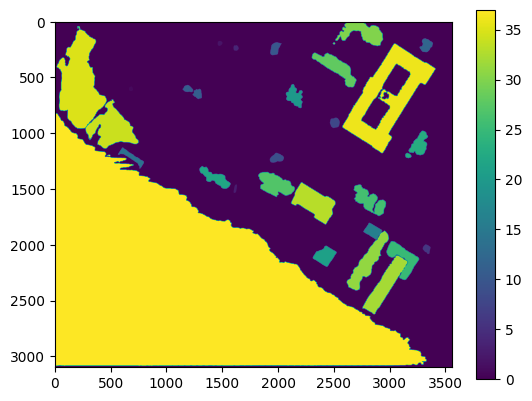

In [6]:
im = plt.imshow(segment_image)
plt.colorbar(im)

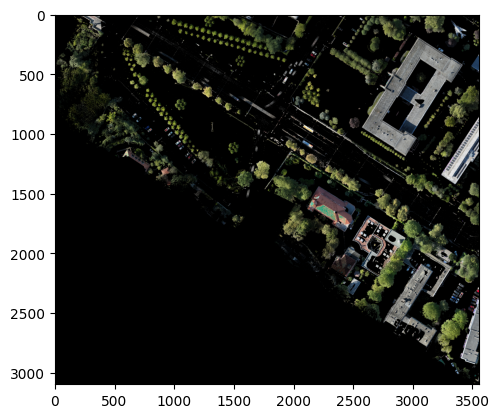

In [7]:
im = plt.imshow(image.transpose(1, 2, 0))

In [8]:
image = image.transpose((1, 2 ,0))

In [9]:
labels = np.unique(segment_image)
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37], dtype=uint8)

In [10]:
segments_img = []

for l in labels:
    mask = np.zeros(image.shape, dtype=int)
    mask[segment_image == l] = [1, 1, 1]
    result = image * mask
    seg = np.argwhere(result)
    if not seg.shape[0] or not seg.shape[1]:
        continue
    minx, maxx = np.min(seg[:, 0]), np.max(seg[:, 0])
    miny, maxy = np.min(seg[:, 1]), np.max(seg[:, 1])
    segments_img.append(result[minx:maxx + 1, miny:maxy + 1])

# Train a clustering model to identify vegetation


In [11]:
kmeans = cluster.KMeans(3, init="k-means++", max_iter=5000, algorithm="elkan")

In [12]:
def resize_image(a: np.ndarray, size: tuple, preserve_aspect_ratio: bool = True, debug: bool = False):
    assert len(a.shape) == 3, "input matrix should have a shape HxWx3"
    assert a.shape[-1] == 3, "input matrix should be a 3 channels image"

    (height, width, _) = a.shape

    (output_height, output_width) = size
    assert  output_height > 0 and output_width > 0

    aspect_ratio = 1.0
    if preserve_aspect_ratio:
        aspect_ratio = float(width) / float(height)
    
    (adjusted_height, adjusted_width) = size
    if aspect_ratio > 1.0:
        adjusted_height = int(output_height * (aspect_ratio - 1))
    elif aspect_ratio < 1.0:
        adjusted_width = int(output_width * aspect_ratio)
    
    offset_x, offset_y = floor(abs(output_width - adjusted_width) / 2), floor(abs(output_height - adjusted_height) / 2)
    assert offset_x >= 0 and offset_y >= 0, "offset_x and offset_y should be equal or greater than zero"
    
    if debug:
        print(f"Input:\theight={height} width={width} (ratio: {aspect_ratio})")
        print(f"Adj:\theight={adjusted_height} width={adjusted_width}")
        print(f"Output:\theight={output_height} width={output_width}")
        print(f"Offset:\tx={offset_x} y={offset_y}")

    result = cv.resize(a.astype('float32'), (adjusted_width, adjusted_height), interpolation=cv.INTER_NEAREST).astype(int)
    result = np.pad(result, [(offset_y, offset_y), (offset_x, offset_x), (0, 0)], mode="constant")

    # Because of round values we can get errors between 1 and -1 pixels
    if result.shape[0] != output_height:
        delta = abs(result.shape[0] - output_height)
        result = np.pad(result, [(0, delta), (0, 0), (0, 0)], mode="constant")
    if result.shape[1] != output_width:
        delta = abs(result.shape[1] - output_width)
        result = np.pad(result, [(0, 0), (0, delta), (0, 0)], mode="constant")
    
    assert result.shape[:-1] == size, "output should match expected size"
    
    return result

In [13]:
training_set = []
ok_set = []
for i in range(0, len(segments_img)):
    try:
        training_set.append(resize_image(segments_img[i], (128, 128)).flatten())
        ok_set.append(resize_image(segments_img[i], (128, 128)))
    except Exception as e:
        print(f"Error for {i}: {e}")
len(training_set)

Error for 30: output should match expected size


37

In [14]:
kmeans.fit(training_set)

KMeans(algorithm='elkan', max_iter=5000, n_clusters=3)

## Test clustering


### With an object


array([2], dtype=int32)

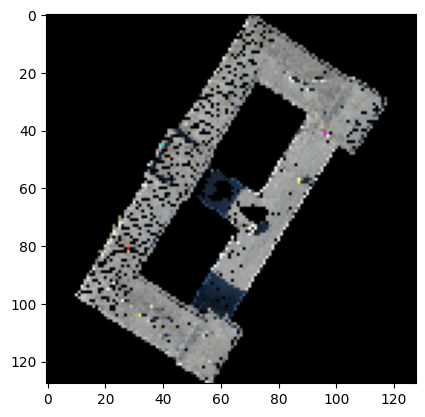

In [15]:
test_img = resize_image(segments_img[36], (128, 128))
plt.imshow(test_img)
kmeans.predict([test_img.flatten()])

### With vegetation


array([2], dtype=int32)

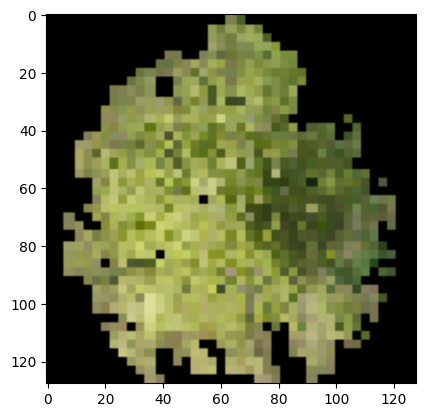

In [16]:
test_img = resize_image(segments_img[1], (128, 128))
plt.imshow(test_img)
kmeans.predict([test_img.flatten()])

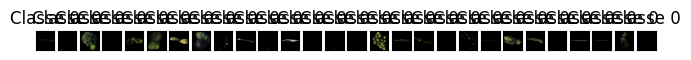

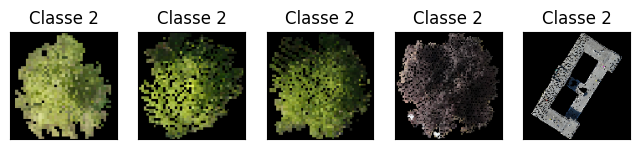

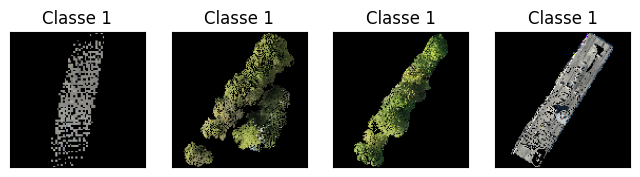

In [17]:
result = dict()
for img, c in zip(ok_set, kmeans.predict(training_set)):
    if result.get(c) is None:
        result.update({c: []})
    
    result.get(c).append(img)

for r in result:
    imgs = result.get(r)
    fig, axs = plt.subplots(1, len(imgs), figsize=(8, 8))
    for x in range(0, len(imgs)):
        if len(imgs) > 1:
            axs[x].imshow(imgs[x])
            axs[x].get_xaxis().set_visible(False)
            axs[x].get_yaxis().set_visible(False)
            axs[x].title.set_text(f'Classe {r}')
        else:
            axs.imshow(imgs[x])
            axs.get_xaxis().set_visible(False)
            axs.get_yaxis().set_visible(False)
            axs.title.set_text(f'Classe {r}')